# AgroDataCube API V2
#### A Big Open Data collection for Agri-Food Applications
https://doi.org/10.18174/455759

***Rob Knapen, Wageningen Environmental Research, The Netherlands***

## 1. Introduction

AgroDataCube provides a large collection of both open data and derived data for use in agri-food applications. It is a work in progress, feel free to join our community on GitHub and the Gitter channel. Links, Postman documentation, and more information can be found on the website https://agrodatacube.wur.nl. This notebook is based on the V2 API of the AgroDataCube. 

Before continuing please request a (free) API token at: https://agrodatacube.wur.nl/api-v2/register.jsp.

The API of AgroDataCube follows REST principles as much as possible, and mostly returns data in GeoJSON format (https://geojson.org). Error responses typically are in plain JSON with a status message as key-value pair. Raster images are returned in GeoTiff format.

In [1]:
# general
import os
import requests
import datetime

# for plotting
import itertools
import geojsonio
import matplotlib.pyplot as plt
from descartes import PolygonPatch

%matplotlib inline

### Prepare for AgroDataCube access
After requesting a token to access the AgroDataCube it is convenient to configure it as an OS environment variable. How to do that differs per operating system. Next it can be easily used be refering to this variable.

In [2]:
# your AgroDataCube access token - replace this code or add the OS environment variable
token = os.environ["AGRODATACUBE_TOKEN"]
header = { "token": token }
base_url="https://agrodatacube.wur.nl/api/v2/rest"

### Retrieving names for crop codes and soil codes
Parcel (field) data in the AgroDataCube is based on the 'Basisregistratie Gewaspercelen' (BRP). A selection of the information from the BRP kept by the Rijksdienst voor Ondernemend Nederland (RVO) is made available as open data. The boundaries of the crop parcels is based on the 'Agrarisch Areaal Nederland' (AAN) dataset. The user of each crop parcel is required every year to indicate the boundaries of each field and the crop grown on it. For each year a BRP dataset is created using May 15 as reference date. 

The RVO maintains the list of crops (code and description/name, in Dutch only) used by this registration. Over the years there are small changes to the list, e.g. edits in the descriptions, or adding of new crop codes. The AgroDataCube tries to keep a harmonised list for all the editions of the BRP it stores, and makes it easy accessible.

Similar the AgroDataCube has a list of soil codes from the bodemkaart 1:50.000, which can be accessed to retrieve the name of a specific soil code.

In [3]:
# AgroDataCube request to retrieve information for a specific crop code.

crop_code = 259

url = base_url + "/codes/cropcodes/{0}".format(crop_code)
cropcode_data = requests.get(url, headers=header)
crop_name = cropcode_data.json()["features"][0]["properties"]["cropname"]
print(crop_name)

Mais, snij-


In [4]:
# AgroDataCube request to retrieve information for a specific soil code.

soil_code = "zHd21_Zd21"

url = base_url + "/codes/soilcodes/{0}".format(soil_code)
soilcode_data = requests.get(url, headers=header)
soil_name = soilcode_data.json()["features"][0]["properties"]["soilname"]
print(soil_name)

Zand


## 2. Crop Parcels

### Request to get the number of items that match the selection criteria
For many purposes it will be needed to retrieve a list of crop parcels from the AgroDataCube, filtered by year, crop code (or name), and location. Since the AgroDataCube uses paging in the requests, it might be handy to know the number of fields matching the filter criteria first. This can be done with the following request.

In [5]:
# Set some selection criteria.

import urllib

# big area geometry for roughly a quarter of NL
geometry  = 'POLYGON((8927 314714, 8927 464932, 138515 464932, 138515 314714, 8927 314714))'

# urlencode the geometry
geometry = urllib.parse.quote(geometry)

# Dutch RD coordinates (currently the AgroDataCube internally uses RD coordinates)
epsg_in = '28992' 

# year to retrieve data for, should be in available range (2014-2018 currently, 2019 data to be added soon)
year = 2018

# 256 = sugarbeets, 262 = zaai-uien, 233 = wintertarwe, 234 = zomertarwe, 259 = snijmais
crop_code = 259

In [6]:
%%time
# Use the result=nrofhits parameter to retrieve only the number of matching fields.
url = base_url + "/fields?year={0}&cropcode={1}&geometry={2}&epsg={3}&result=nrofhits&noclip&page_size=1&page_offset=0".format(
    year, crop_code, geometry, epsg_in)
print (url)
response = requests.get(url, headers=header)

# Note that this request returns geojson (for uniformity of responses), so some digging is needed to get to the number of hits (matches)
print ("Number of features in selection:", response.json()['features'][0]['properties']['nrofhits'])

https://agrodatacube.wur.nl/api/v2/rest/fields?year=2018&cropcode=259&geometry=POLYGON%28%288927%20314714%2C%208927%20464932%2C%20138515%20464932%2C%20138515%20314714%2C%208927%20314714%29%29&epsg=28992&result=nrofhits&noclip&page_size=1&page_offset=0
Number of features in selection: 10344
CPU times: user 24.8 ms, sys: 4.34 ms, total: 29.1 ms
Wall time: 4.33 s


### Retrieve selected parcel properties, without geometry (quicker)
Working with geometries of parcels typically slows things down since it requires additional data to be transferred and spatial calculations to be performed. When the geometry is not needed it is possible to exclude it from the response, and also to force AgroDataCube to not clip boundaries by the search geometry (which is the default behaviour). Using these parameters (result=nogeom and noclip) increases the performance of a request.

In [7]:
%%time
# Use the result=nogeom and noclip parameters to avoid geometry overhead when possible.
url = base_url + "/fields?year={0}&cropcode={1}&geometry={2}&epsg={3}&result=nogeom&noclip&page_size=1&page_offset=0".format(
    year, crop_code, geometry, epsg_in)
fields = requests.get(url, headers=header)
print (fields.json()['features'][0])

{'type': 'Feature', 'geometry': None, 'properties': {'fieldid': 8077197, 'perimeter': 2702.338, 'year': 2018, 'area': 251385.347, 'crop_name': 'Mais, snij-', 'grondgebruik': 'Bouwland', 'crop_code': '259'}}
CPU times: user 22.5 ms, sys: 3.66 ms, total: 26.2 ms
Wall time: 4.29 s


### Retrieve selected field properties, including geometry (slower)

In [8]:
%%time
# By default the parcel geometry will be included in the response, making it slower.
url = base_url + "/fields?year={0}&cropcode={1}&geometry={2}&epsg={3}&page_size=1&page_offset=0".format(
    year, crop_code, geometry, epsg_in)
fields = requests.get(url, headers=header)
print (fields.json()['features'][0]['properties'])

{'fieldid': 8077197, 'perimeter': 2702.338, 'year': 2018, 'area': 251385.347, 'crop_name': 'Mais, snij-', 'grondgebruik': 'Bouwland', 'crop_code': '259'}
CPU times: user 23.6 ms, sys: 4.18 ms, total: 27.8 ms
Wall time: 7.37 s


### Get properties and geometry for a specific field (fast)
Once you know the ID of a field (fieldid in the response) it provides the fastest way to retrieve all data about that specific field. 

In [9]:
%%time
url = base_url + "/fields/{0}?output_epsg={1}&noclip&page_size=1&page_offset=0".format(8083517, '28992')
field = requests.get(url, headers=header)
print (field.json()['features'][0]['properties'])

{'fieldid': 8083517, 'perimeter': 33351.542, 'year': 2018, 'area': 20268696.478, 'crop_name': 'Natuurterreinen (incl. heide)', 'grondgebruik': 'Natuurterrein', 'crop_code': '335'}
CPU times: user 20.9 ms, sys: 3.05 ms, total: 23.9 ms
Wall time: 41.5 ms


### Plotting fields
With the geometry of a parcel it is easy to draw it or e.g. display it on a map. Note that the AgroDataCube is not designed for fancy GIS purposes or as backend for GIS clients, and there is currently no support for OGC WFS or WMS web services. For that it is easier to connect to https://www.pdok.nl. 

In [10]:
# Get some parcels (without geometries) to play with.
url = base_url + "/fields?year={0}&cropcode={1}&geometry={2}&epsg={3}&result=nogeom&noclip&page_size=100&page_offset=0".format(
    year, crop_code, geometry, epsg_in)
fields = requests.get(url, headers=header)

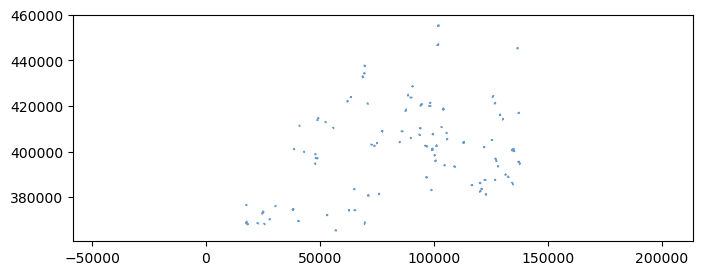

CPU times: user 2.14 s, sys: 155 ms, total: 2.3 s
Wall time: 4 s


In [11]:
%%time
# Plot all the parcels, retrieving geometry for each one on-the-fly.
BLUE = '#6699cc'
fig = plt.figure(figsize=(8,3), dpi=100)
ax = fig.gca()
for f in fields.json()["features"]:
    # get the field data (including geometry) to plot it
    url = base_url + "/fields/{0}?output_epsg={1}&noclip&page_size=1&page_offset=0".format(f['properties']['fieldid'], '28992')
    field = requests.get(url, headers=header)
    geometry = field.json()['features'][0]['geometry']
    ax.add_patch(PolygonPatch(geometry, fc=BLUE, ec=BLUE, alpha=1.0, zorder=2))
ax.axis('equal')
plt.show()

## 3. Height Information
The AgroDataCube stores height data from 'Actueel Hoogtebestand Nederland' (AHN, http://www.ahn.nl/). It is made available in two ways: (i) as zonal statistics calculated per parcel, and (ii) as raster data.

### Statistical data

In [12]:
# Get the height statistics for 5 parcels.
for field in fields.json()["features"][0:5]:
    field_id = field["properties"]["fieldid"]
    url = base_url + "/fields/{0}/ahn".format(field_id)
    ahn_data = requests.get(url, headers=header)
    ahn = ahn_data.json()
    print(ahn["features"][0]["properties"])

{'max': 2281.4, 'mean': 2209.781, 'min': 2135.7, 'area': 251385.347}
{'max': 177.0, 'mean': 108.697, 'min': 14.0, 'area': 241996.373}
{'max': -471.2, 'mean': -521.332, 'min': -568.4, 'area': 216881.008}
{'max': 217.7, 'mean': 175.166, 'min': 89.1, 'area': 210052.581}
{'max': 64.3, 'mean': 1.138, 'min': -82.5, 'area': 205630.997}


### Raster data

https://agrodatacube.wur.nl/api/v2/rest/fields/8081619/ahn_image?output_epsg=28992
BoundingBox(left=68567.37720969625, bottom=432419.155475431, right=69107.92591530373, top=433149.6736495689)
EPSG:28992


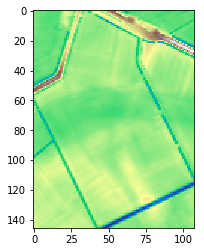

CPU times: user 367 ms, sys: 121 ms, total: 488 ms
Wall time: 1.14 s


In [13]:
%%time
# Get the AHN raster data for a parcel and plot it.
import rasterio
from rasterio.io import MemoryFile
from rasterio.plot import show

# https://rasterio.readthedocs.io/en/stable/intro.html

fig, ax = plt.subplots(1)

field_id = fields.json()["features"][4]['properties']['fieldid']
    
url = base_url + "/fields/{0}/ahn_image?output_epsg={1}".format(field_id, 28992)
print (url)
response = requests.get(url, headers=header)
raw_raster_data = response.content

with MemoryFile(raw_raster_data) as memfile:
    with memfile.open() as dataset:
        print(dataset.bounds)
        print(dataset.crs)
        data_array = dataset.read()
        show(data_array[0], cmap='terrain', interpolation='none', ax=ax)

plt.show()

https://agrodatacube.wur.nl/api/v2/rest/fields/8081619/ahn_image?output_epsg=28992
BoundingBox(left=68567.37720969625, bottom=432419.155475431, right=69107.92591530373, top=433149.6736495689)
EPSG:28992


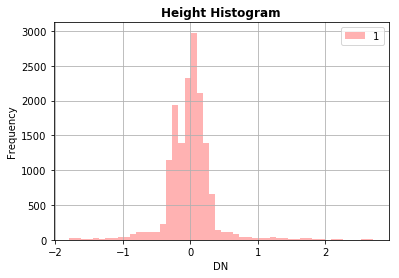

CPU times: user 335 ms, sys: 44.2 ms, total: 379 ms
Wall time: 473 ms


In [14]:
%%time
# Display AHN height distribution for a parcel.
import rasterio
from rasterio.io import MemoryFile
from rasterio.plot import show_hist

field_id = fields.json()["features"][4]['properties']['fieldid']
    
url = base_url + "/fields/{0}/ahn_image?output_epsg={1}".format(field_id, 28992)
print (url)
response = requests.get(url, headers=header)
raw_raster_data = response.content

with MemoryFile(raw_raster_data) as memfile:
    with memfile.open() as dataset:
        print(dataset.bounds)
        print(dataset.crs)
        data_array = dataset.read()
        show_hist(data_array, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title='Height Histogram')


## 3. Vegetation Index (NDVI)
AgroDataCube contains an advanced NDVI (normalized difference vegetation index) calculated from multiple sensors (satellites) after atmospheric corrections and calibrations.  The NDVI is a simple graphical indicator that can be used to analyze remote sensing measurements and assess whether the target being observed contains live green vegetation or not. Again it is made available as (i) zonal statistics per parcel, and (ii) as raster data.

### Statistical data
The statistical data is a timeseries for each parcel, based on dates that had usable satellite data (depending on revisiting times, cloud cover, etc.). From each usable image the statistics (average NDVI value and standard deviation) have been calculated per parcel, and stored. They can serve nicely to study crop phenology over time and for a large number of crop parcels.

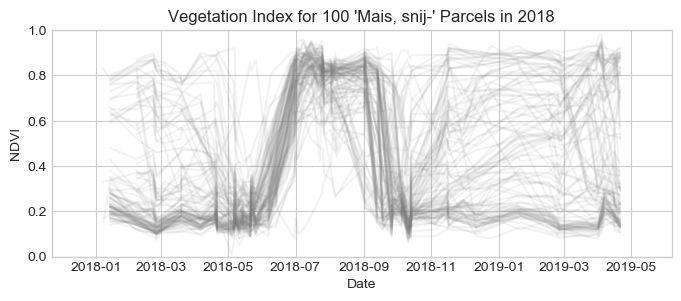

In [15]:
# plot ndvi data for all fields
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
 
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(8, 3), dpi=100)
ax = plt.axes()
ax.set_xmargin(0.1)
ax.set_alpha(0.5)
ax.autoscale(True)
ax.xaxis_date()

for field in fields.json()["features"]:
    field_id = field["properties"]["fieldid"]
    ndvi_url = base_url + "/fields/{0}/ndvi?fromdate={1}&todate={2}&page_size=1000".format(field_id, year-1, year+1)
    ndvi_data = requests.get(ndvi_url, headers=header)
    ndvi_timeseries = ndvi_data.json()
    
    dates = []
    values = []
    for feature in ndvi_timeseries["features"]:
        ndvi_avg = feature["properties"]["ndvi_avg"]
        ndvi_stddev = feature["properties"]["ndvi_stddev"]
        # filter out the no-data records (ndvi_avg == 0.0)
        if (ndvi_avg > 0.0):
            dates.append(datetime.datetime.strptime(feature["properties"]["datum"], '%Y-%m-%d').date())
            values.append(ndvi_avg)
    
    ax.plot(dates, values, color='grey', alpha=0.1)

ax.set(ylim=(0.0, 1.0), xlabel='Date', ylabel='NDVI', title="Vegetation Index for {0} '{1}' Parcels in {2}".format(len(fields.json()["features"]), crop_name, year));

### Raster data
It is also possible to retrieve the NDVI data as raster image (10m grid cells) per parcel, for each date when there is an image available. This can be derived from the statistics timeseries. The raster data can then be displayed or further analyised.

https://agrodatacube.wur.nl/api/v2/rest/fields/8081619/ndvi_image?date=20180526&output_epsg=28992


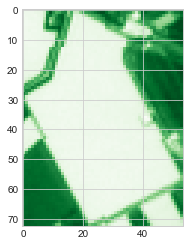

CPU times: user 310 ms, sys: 30.8 ms, total: 341 ms
Wall time: 402 ms


In [38]:
%%time
import rasterio
from rasterio.io import MemoryFile
from rasterio.plot import show

fig, ax = plt.subplots(1)

field_id = fields.json()["features"][4]['properties']['fieldid']

# need to supply the date for the image to retrieve
url = base_url + "/fields/{0}/ndvi_image?date={1}&output_epsg={2}".format(field_id, "20180526", 28992)
print (url)
response = requests.get(url, headers=header)
raw_raster_data = response.content

with MemoryFile(raw_raster_data) as memfile:
    with memfile.open() as dataset:
        data_array = dataset.read()
        show(data_array[0], cmap='Greens', interpolation='none', ax=ax)
        
plt.show()

https://agrodatacube.wur.nl/api/v2/rest/fields/8081619/ndvi_image?date=20180526&output_epsg=28992
BoundingBox(left=68567.37975, bottom=432419.15725, right=69107.923375, top=433149.671875)
EPSG:28992


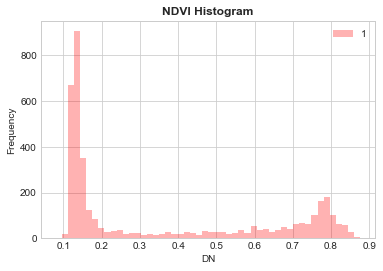

CPU times: user 349 ms, sys: 39.2 ms, total: 388 ms
Wall time: 450 ms


In [37]:
%%time
# Display NDVI distribution for a parcel.
import rasterio
from rasterio.io import MemoryFile
from rasterio.plot import show_hist

field_id = fields.json()["features"][4]['properties']['fieldid']
    
url = base_url + "/fields/{0}/ndvi_image?date={1}&output_epsg={2}".format(field_id, "20180526", 28992)
print (url)
response = requests.get(url, headers=header)
raw_raster_data = response.content

with MemoryFile(raw_raster_data) as memfile:
    with memfile.open() as dataset:
        print(dataset.bounds)
        print(dataset.crs)
        data_array = dataset.read()
        show_hist(data_array, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title='NDVI Histogram')

## 4. Soil Information
The AgroDataCube provides soil information from the 'Bodemkaart 1:50.000' (https://www.wur.nl/nl/show/Bodemkaart-1-50-000.htm), and from the map of soil physical parameters (https://www.wur.nl/nl/show/Bodemfysische-Eenhedenkaart-BOFEK2012.htm). The soil information is very extensive, and when retrieving it for a parcel you typically get multiple types of soils present.

In [19]:
# Requesting soil types per parcel.
# For more information please see this site: https://www.wur.nl/nl/show/Bodemkaart-1-50-000.htm

for field in fields.json()["features"][0:3]:
    field_id = field["properties"]["fieldid"]
    soiltypes_url = base_url + "/fields/{0}/soiltypes".format(field_id)
    print (soiltypes_url)
    soiltypes_data = requests.get(soiltypes_url, headers=header)
    soiltypes = soiltypes_data.json()
    
    for soiltype in soiltypes["features"][0:3]:
        print(soiltype["properties"])
        soiltype_url = base_url + "/codes/soilcodes/{0}".format(soiltype["properties"]["soilunits"][0]["soil_code"])
        print (soiltype_url)
        soiltype_data = requests.get(soiltype_url, headers=header)
        soil = soiltype_data.json()
        print(soil["features"][0]["properties"])

https://agrodatacube.wur.nl/api/v2/rest/fields/8077197/soiltypes
{'perimeter': 11386.943, 'area': 251385.347, 'id': 19288, 'soilunits': [{'id': 19288, 'soil_code': 'Hn21', 'achter': 'g', 'soilname': 'Zand', 'soiltype': 'Podzolgronden'}]}
https://agrodatacube.wur.nl/api/v2/rest/codes/soilcodes/Hn21
{'soilcode': 'Hn21/Zd21', 'soilname': 'Zand', 'soiltype': 'Podzolgronden'}
https://agrodatacube.wur.nl/api/v2/rest/fields/7851622/soiltypes
{'perimeter': 27151.925, 'area': 236932.334, 'id': 30675, 'soilunits': [{'id': 30675, 'soil_code': 'Mn35A', 'soilname': 'Lichte klei', 'soiltype': 'Zeekleigronden'}]}
https://agrodatacube.wur.nl/api/v2/rest/codes/soilcodes/Mn35A
{'soilcode': 'Mv61C/Mn35Av', 'soilname': 'Zware zavel', 'soiltype': 'Zeekleigronden'}
{'perimeter': 6446.866, 'area': 5064.039, 'id': 33904, 'soilunits': [{'id': 33904, 'soil_code': 'Mn45A', 'soilname': 'Zware klei', 'soiltype': 'Zeekleigronden'}]}
https://agrodatacube.wur.nl/api/v2/rest/codes/soilcodes/Mn45A
{'soilcode': 'Mn45Av/

In [35]:
# Requesting soil physical parameters per parcel.
# For more information please see this site: https://www.wur.nl/nl/show/Bodemfysische-Eenhedenkaart-BOFEK2012.htm

import pandas as pd
from pandas.io.json import json_normalize

field_id = fields.json()["features"][0]["properties"]["fieldid"]
soilparams_url = base_url + "/fields/{0}/soilparams?result=nogeom".format(field_id)
print (soilparams_url)
soilparams_data = requests.get(soilparams_url, headers=header)
soilparams = soilparams_data.json()

# use Pandas to normalize data into a DataFrame
params_df = json_normalize(soilparams['features'][0]['properties']['bofek_profiles'][0]['bofek2012_layers'])
params_df.head(5)

https://agrodatacube.wur.nl/api/v2/rest/fields/8077197/soilparams?result=nogeom


,a_waarde,bofek2012,cac03,dichtheid,diepte_b,diepte_o,hor_code,laag_nr,landuse,leem,...,materiaal,orgstof,orgstof_p10,orgstof_p90,ph_kcl,ph_p10,ph_p90,silt,soil_nr,staring_bouwsteen
0,1,305,0.0,1.390890,0.0,25.0,1Ap,1,G,11.0,...,410.0,5.0,2.0,8.0,4.8,4.2,5.2,8.0,4020,B2
1,0,305,0.0,1.568150,25.0,35.0,1Bhe,2,G,9.0,...,410.0,2.4,0.8,5.0,4.5,4.0,5.0,7.0,4020,O1
2,0,305,0.0,1.634163,35.0,55.0,1BCe,3,G,9.0,...,410.0,1.0,0.4,2.0,4.5,4.0,5.0,7.0,4020,O1
3,0,305,0.0,1.669299,55.0,90.0,1Cg1,4,G,9.0,...,410.0,0.3,0.1,1.0,4.7,4.0,5.0,7.0,4020,O1
4,0,305,0.0,1.576363,90.0,120.0,1Cg2,5,G,7.0,...,410.0,0.3,0.1,1.0,4.7,4.0,5.0,5.0,4020,O5


## 5. Weather Information
Timeseries of weather data from the Royal Dutch Metereological Institute (KNMI, https://www.knmi.nl/) are also available from the AgroDataCube. The observation data from 50 major meteostations in The Netherlands has been added. For each parcel the distance to the available meteostations has been calculated and a list of the 5 nearest can be retrieved. These can then be used to retrieve available timeseries of meteodata and for example combine them to create a complete timeseries. Meteostations might sometimes go out of service or have incomplete measurements.

In [36]:
# weather data from meteostation nearest to a parcel.

import pandas as pd
from pandas.io.json import json_normalize

# Retrieve meteodata for a parcel.
field_id = fields.json()["features"][0]["properties"]["fieldid"]
meteostations_url = base_url + "/fields/{0}/meteostations".format(field_id)
meteostations_data = requests.get(meteostations_url, headers=header)
meteostations = meteostations_data.json()
print(meteostations['features'][0]['properties'])
    
# meteostations with index 0 (rank=1) is the nearest to the field
meteostation_id = meteostations["features"][0]["properties"]["meteostationid"]
# get meteodata for a certain date range
meteodata_url = base_url + "/meteodata?meteostation={0}&fromdate={1}&todate={2}&page_size=1000".format(meteostation_id, year, year)
meteodata_data = requests.get(meteodata_url, headers=header)
meteodata = meteodata_data.json()
    
# use Pandas to normalize data into a DataFrame
meteo_df = json_normalize(meteodata['features'])
meteo_df.head(5)

{'meteostationid': 350, 'name': 'Gilze-Rijen', 'wmocode': 63500, 'lon': 4.936, 'lat': 51.566, 'alt': 11.95, 'source': 'KONINKLIJK NEDERLANDS METEOROLOGISCH INSTITUUT (KNMI) (http://www.knmi.nl/klimatologie/metadata/debilt.html)', 'provider': 'KNMI_DAILY', 'rank': 1, 'distance': 15279.2993, 'fieldid': 8077197}


,geometry,properties.datum,properties.global_radiation,properties.max_humidity,properties.max_temperature,properties.mean_daily_cloud_cover,properties.mean_humidity,properties.mean_sea_level_pressure,properties.mean_temperature,properties.meteostationid,properties.min_temperature,properties.potential_evapotranspiration,properties.precipitation,properties.sunshine_duration,properties.windspeed,type
0,None,2018-01-01,233.0,96.0,9.0,7.0,85.0,999.5,6.6,350,4.8,0.3,8.5,2.2,4.9,Feature
1,None,2018-01-02,183.0,95.0,9.5,8.0,88.0,1006.6,6.7,350,5.5,0.2,3.9,0.2,5.4,Feature
2,None,2018-01-03,94.0,94.0,11.5,8.0,71.0,993.2,9.1,350,6.5,0.1,10.3,0.2,8.9,Feature
3,None,2018-01-04,77.0,96.0,11.8,7.0,82.0,994.8,8.4,350,6.5,0.1,1.4,0.0,5.6,Feature
4,None,2018-01-05,181.0,96.0,9.6,6.0,87.0,996.6,6.9,350,4.4,0.2,8.5,0.0,4.0,Feature


## 6. Administrative Regions
For looking up crop parcels and aggregating results, e.g. after data analysis, the AgroDataCube provides data on administrative boundaries of Dutch provinces, municipalities, and zip code areas. The following example demonstrates the use of the province data.

In [39]:
prov_name = "Noord-Holland" # name of provence to find crop fields for (e.g. Fryslân, or Noord-Holland)

In [40]:
# read info on all Dutch provinces of 2015
prov_url = base_url + "/regions/provences?page_size=25&output_epsg=28992&page_offset=0"
prov_data = requests.get(prov_url, headers=header)
prov = prov_data.json()

Fryslân Gelderland Noord-Brabant Noord-Holland Overijssel Zuid-Holland Groningen Zeeland Drenthe Flevoland Limburg Utrecht 

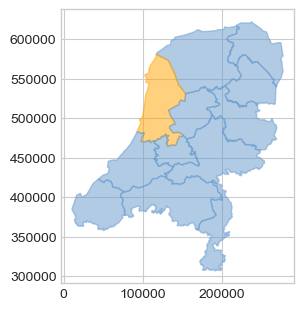

In [41]:
# plot all provinces as a map
BLUE = '#6699cc'
ORANGE = '#ffa500'
fig = plt.figure(figsize=(3,6), dpi=100)
ax = fig.gca()
for p in prov["features"]:
    print(p["properties"]["name"], end=' ')
    color = ORANGE if p["properties"]["name"] == prov_name else BLUE
    ax.add_patch(PolygonPatch(p["geometry"], fc=color, ec=color, alpha=0.5, zorder=2))
ax.axis('scaled')
plt.show()

In [47]:
# Calculate bounding box of the province.
area = [p for p in prov["features"] if p["properties"]["name"] == prov_name][0]["geometry"]["coordinates"][0]

x_min = 300000
x_max = 0
y_min = 700000
y_max = 300000

for polygon in area:
    for coordinate in polygon:
        if coordinate[0] < x_min:
            x_min = coordinate[0]
        if coordinate[0] > x_max:
            x_max = coordinate[0]
        if coordinate[1] < y_min:
            y_min = coordinate[1]
        if coordinate[1] > y_max:
            y_max = coordinate[1]
            
# create a wkt geometry for the bounding box and urlencode it
geom = "POLYGON(({0:.0f} {1:.0f}, {0:.0f} {3:.0f}, {2:.0f} {3:.0f}, {2:.0f} {1:.0f}, {0:.0f} {1:.0f}))".format(x_min, y_min, x_max, y_max)

import urllib
geom = urllib.parse.quote(geom)
print(geom)

POLYGON%28%2892957%20464238%2C%2092957%20581000%2C%20154329%20581000%2C%20154329%20464238%2C%2092957%20464238%29%29


In [49]:
# Now get the total number of parcels within a specific year, with a certain crop, inside the bounding box of the province
url = base_url + "/fields?year={0}&cropcode={1}&geometry={2}&epsg={3}&result=nrofhits&noclip&page_size=1&page_offset=0".format(year, crop_code, geom, "28992")
response = requests.get(url, headers=header)
print("Number of '{0}' parcels in {1}: {2}".format(crop_name, year, response.json()['features'][0]['properties']['nrofhits']))

Number of 'Mais, snij-' parcels in 2018: 1817


## Final Remarks
I hope the examples in this notebook are helpful for figuring out how to work with AgroDataCube. More details about API can be found in the Postman documentation, please visit the AgroDataCube website (https://agrodatacube.wur.nl) for the link. And, if you have other code examples you want to share or already put on GitHub please let me know.